## Introduction<a id='introduction'></a>

**Purpose:**

Explore dataset to get a sense of which features are most predictive of EFS.

**Context:**

Hematopoietic stem cells, which reside in the bone marrow, are responsible for generating all blood cells, including red blood cells, platelet-producing cells, and immune system cells such as T cells, B cells, neutrophils, and natural killer cells. Allogeneic hematopoietic cell transplantation (HCT) can replace an individual's faulty hematopoietic stem cells with functional ones restoring healthy immune system function. 

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

The goal of the project is to predict an individual's risk score. (Target variable is ```efs```)

**Data:**

Project and data comes from [Kaggle](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/overview)

**Outcomes of EDA:**

1. Risk, patient, and HCT models result in similar accuracies in the range of 0.62-0.64 while donor-recipient models result in accuracies in the range of 0.56-0.58
2. PCA generally results in increased accuracies especially for reducing the number of dimensions in hla features, hct features, and patient features
3. Dropping features can result in increased accuracy suggesting that there is substantial noise in the dataset
4. Need to go through and drop all feature values that appear less 1% of the time

**Outcomes from this notebook (Preprocessing):**

1. Removed rare occurences
2. Converted age to categories following prognostic factors identified from UpToDate
3. Binned Sorror comorbidity score
4. Target encoding led to minimal improvements in performance
5. Trained using efs, efs_time, and kaplan meier survival
    - efs produced best result, but could be model dependent

## Contents<a id='contents'></a>
* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Preprocessing and Feature Engineering](#preprocessing_and_feature_engineering)
* [Training](#Training)
* [Summary](#summary)

## Objectives<a id='objectives'></a>

1. Preprocess data for training
2. Train models to predict EFS

## Setting up notebook

### Loading Environment

In [1]:
import numpy as np
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 12, 'figure.figsize':(4,3)})

C:\Users\kimvo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+s for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)

        X_cat = X_cat.drop(columns=X_cat.columns[pd.Series(X_cat.columns.values).str.contains('NOT TESTED')])

        return X_cat

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scaler = StandardScaler()
        X_num = pd.DataFrame(scaler.fit_transform(X[self.columns]), columns=self.columns)
        return X_num

In [4]:
data = pd.read_csv('../data/interim/train.csv')

## Preprocessing and Feature Engineering<a id='preprocessing_and_feature_engineering'></a>

See subsections for additional information on age categorization, combining targets, and target encoding

In [169]:
def remove_rare_vals(df, threshold=0.01):
    '''
    Remove categorical values which appear less than the threshold frequency
    '''
    cols = df.columns.values
    threshold = int(df.shape[0]*threshold)

    new_df = pd.DataFrame()

    for col in cols:
        remove_vals = []
        for key, val in df[col].value_counts().to_dict().items():
            if val < threshold:
                remove_vals.append(key)

        new_series = []
        for x in df[col]:
            if x in remove_vals:
                new_series.append('NOT TESTED')
            else:
                new_series.append(x)

        new_df[col] = new_series

    return new_df

def categorize_age(my_arr):
    '''
    Bin age according to thresholds identified from UpToDate
    '''
    age_cat = []
    for x in my_arr:
        if pd.isna(x):
            age_cat.append('NOT TESTED')
        elif x < 1: # 6
            age_cat.append('Infant')
        elif x < 18: # 25
            age_cat.append('Child')
        elif x < 40: # 45
            age_cat.append('Young Adult')
        elif x < 65: # 65
            age_cat.append('Adult')
        else:
            age_cat.append('Senior')
    return age_cat

def bin_comorbidity(my_arr):
    '''
    Bin Sorror comorbidity according to bins identified from HCT-CI
    '''
    return [str(x) if x < 4 else '4' for x in my_arr]

def red_dri_score(df):
    '''
    Reduces the cardinality of dri_score by mapping values to one another based on similarity to target
    '''
    new_arr = []
    for val in df['dri_score']:
        if val == 'High':
            new_arr.append('High')
        elif val in ['High - TED AML case <missing cytogenetics', 'Intermediate', 'Intermediate - TED AML case <missing cytogenetics', 'Low']:
            new_arr.append('Intermediate')
        else:
            new_arr.append('Low')
    return new_arr

def te_feature_mean(df, col):
    '''
    Target encode feature using mean of kaplan meier survival function
    '''
    mapper = df[[col, 'y_km']].groupby(col).mean().to_dict()['y_km']
    return df[col].replace(mapper)

In [170]:
object_cols = list(data.columns[data.dtypes.values == 'O'])
num_cols = data.columns[(data.dtypes.values == 'int64') | (data.dtypes.values == 'float64')].drop(['Unnamed: 0', 'ID', 'year_hct'])

df = remove_rare_vals(data[object_cols])
df[num_cols] = data[num_cols]
df['age_at_hct_cat'] = categorize_age(data['age_at_hct'])
df['binned_comorbidity'] = bin_comorbidity(data['comorbidity_score'])
df['donor-pt_age'] = df['donor_age'] - df['age_at_hct']

km = KaplanMeierFitter()
km.fit(df['efs_time'], df['efs'])
df['y_km'] = km.survival_function_at_times(df['efs_time']).values

na = NelsonAalenFitter()
na.fit(durations=df['efs_time'], event_observed=df['efs'])
df['y_na'] = -na.cumulative_hazard_at_times(df['efs_time']).values

df['dri_score_red'] = red_dri_score(df)
df['te_dri_score'] = te_feature_mean(df, 'dri_score')
df['te_prim_disease_hct'] = te_feature_mean(df, 'prim_disease_hct')
df['te_gvhd_proph'] = te_feature_mean(df, 'gvhd_proph')

df['pt_sex'] = df['sex_match'].replace({'M-M':'M', 'F-M':'M', 'M-F':'F', 'F-F':'F'})
df['dr_sex_match'] = df['sex_match'].replace({'M-M':1, 'F-M':-1, 'M-F':-1, 'F-F':1, 'NOT TESTED':0})

C:\Users\kimvo\AppData\Local\Temp\ipykernel_7420\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].replace(mapper)
C:\Users\kimvo\AppData\Local\Temp\ipykernel_7420\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].replace(mapper)
C:\Users\kimvo\AppData\Local\Temp\ipykernel_7420\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. 

### Removing Rare Values and Categorizing Age

In [5]:
my_df = data
my_df['donor-pt_age'] = my_df['donor_age']-my_df['age_at_hct']

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


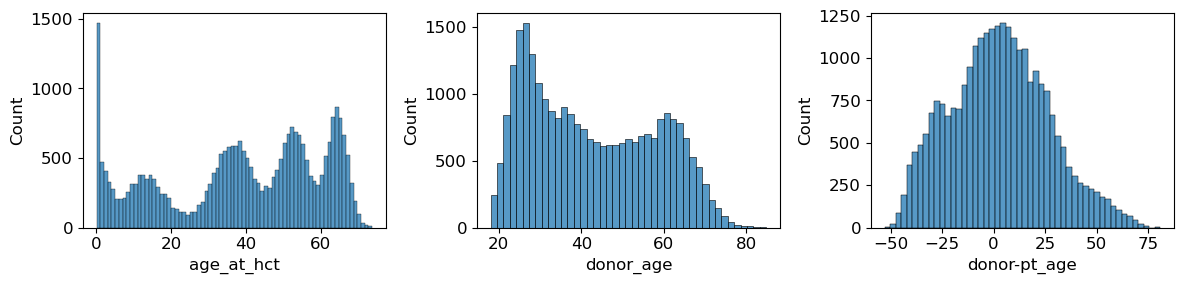

In [6]:
plt.figure(figsize=(12, 3))
plt.subplot(1,3,1)
sns.histplot(data=my_df, x='age_at_hct', bins=74)
plt.subplot(1,3,2)
sns.histplot(data=my_df, x='donor_age', bins=43)
plt.subplot(1,3,3)
sns.histplot(data=my_df, x='donor-pt_age', bins=50)
plt.tight_layout()

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age_at_hct', ylabel='Count'>

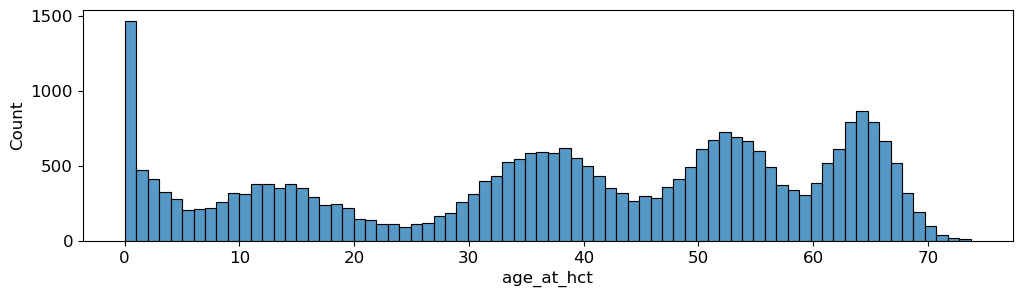

In [7]:
plt.figure(figsize=(12, 3))
sns.histplot(data=my_df, x='age_at_hct', bins=74)

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='donor-pt_age', ylabel='Count'>

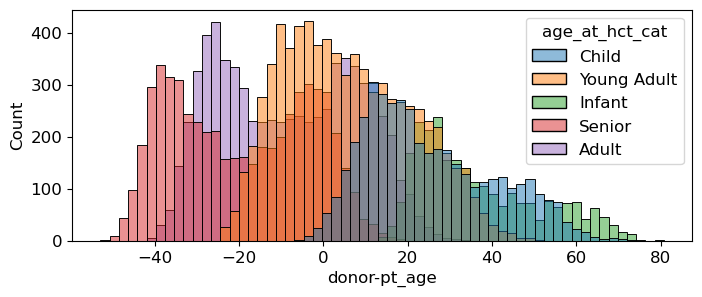

In [10]:
plt.figure(figsize=(8,3))
sns.histplot(data=df, x='donor-pt_age', hue='age_at_hct_cat')

### Transforming Two Targets into One Target

In [11]:
km = KaplanMeierFitter()
km.fit(df['efs_time'], df['efs'])
df['y_km'] = km.survival_function_at_times(df['efs_time']).values

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='y_km', ylabel='Count'>

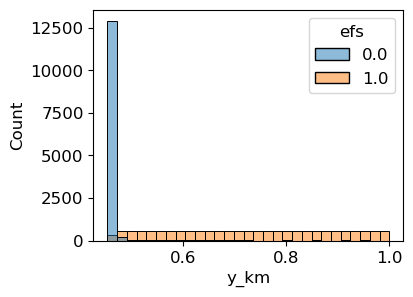

In [12]:
sns.histplot(data=df, x='y_km', hue='efs')

In [13]:
na = NelsonAalenFitter()
na.fit(durations=df['efs_time'], event_observed=df['efs'])
df['y_na'] = -na.cumulative_hazard_at_times(df['efs_time']).values

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='y_na', ylabel='Count'>

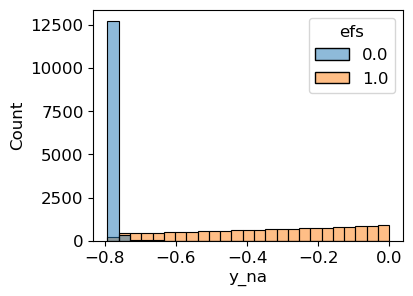

In [14]:
sns.histplot(data=df, x='y_na', hue='efs')

### Target Encoding

In [15]:
len(object_cols)

34

In [16]:
for col in object_cols:
    print(col, df[col].nunique(), list(df[col].value_counts().items()))

dri_score 9 [('Intermediate', 10436), ('N/A - pediatric', 4779), ('High', 4701), ('N/A - non-malignant indication', 2427), ('NOT TESTED cytogenetics', 2003), ('Low', 1926), ('High - TED AML case <missing cytogenetics', 1414), ('NOT TESTED', 633), ('Intermediate - TED AML case <missing cytogenetics', 481)]
psych_disturb 3 [('No', 23005), ('Yes', 3587), ('NOT TESTED', 2208)]
cyto_score 6 [('NOT TESTED', 9464), ('Poor', 8802), ('Intermediate', 6376), ('Favorable', 3011), ('Normal', 643), ('Other', 504)]
diabetes 3 [('No', 22201), ('Yes', 4339), ('NOT TESTED', 2260)]
tbi_status 5 [('No TBI', 18861), ('TBI + Cy +- Other', 6104), ('TBI +- Other, <=cGy', 1727), ('TBI +- Other, >cGy', 1700), ('NOT TESTED', 408)]
arrhythmia 3 [('No', 25203), ('NOT TESTED', 2320), ('Yes', 1277)]
graft_type 2 [('Peripheral blood', 20546), ('Bone marrow', 8254)]
vent_hist 3 [('No', 27721), ('Yes', 820), ('NOT TESTED', 259)]
renal_issue 2 [('No', 26548), ('NOT TESTED', 2252)]
pulm_severe 3 [('No', 24779), ('NOT TES

Candidates for target engineering are 
```dri_score, prim_disease_hct, gvhd_proph```

#### dri_score
**Result:** Features can be  grouped by similarity in target statistics. Can either group to reduce cardinality or use target encoding

In [18]:
df[['dri_score', 'efs', 'efs_time', 'y_km']].groupby('dri_score').mean()

,efs,efs_time,y_km
dri_score,,,
High,0.705807,17.339421,0.694500
High - TED AML case <missing cytogenetics,0.586987,22.659573,0.619092
Intermediate,0.587677,22.339081,0.589615
Intermediate - TED AML case <missing cytogenetics,0.550936,24.303353,0.585777
Low,0.593458,24.333374,0.594931
N/A - non-malignant indication,0.388546,27.304484,0.580602
N/A - pediatric,0.389831,26.806018,0.583353
NOT TESTED,0.396524,26.359817,0.582261
NOT TESTED cytogenetics,0.392411,26.433116,0.584943


In [19]:
df[['dri_score', 'efs', 'efs_time', 'y_km']].groupby('dri_score').sem()

,efs,efs_time,y_km
dri_score,,,
High,0.006647,0.342199,0.002854
High - TED AML case <missing cytogenetics,0.013099,0.695128,0.004852
Intermediate,0.004819,0.239072,0.001508
Intermediate - TED AML case <missing cytogenetics,0.022703,1.188615,0.007369
Low,0.011195,0.637164,0.003684
N/A - non-malignant indication,0.009896,0.506958,0.003585
N/A - pediatric,0.007056,0.351105,0.002602
NOT TESTED,0.019458,0.947899,0.007111
NOT TESTED cytogenetics,0.010913,0.526938,0.004046


In [20]:
df[['dri_score', 'efs', 'efs_time', 'y_km']].groupby('dri_score').std()

,efs,efs_time,y_km
dri_score,,,
High,0.455727,23.462458,0.195659
High - TED AML case <missing cytogenetics,0.492549,26.139026,0.182455
Intermediate,0.492276,24.422790,0.154098
Intermediate - TED AML case <missing cytogenetics,0.497917,26.068359,0.161624
Low,0.491316,27.962709,0.161662
N/A - non-malignant indication,0.487520,24.975091,0.176607
N/A - pediatric,0.487763,24.271986,0.179892
NOT TESTED,0.489563,23.848651,0.178916
NOT TESTED cytogenetics,0.488409,23.583052,0.181079


#### prim_disease_hct
**Result:** Features cannot be easily grouped by similarity in target statistics, best option appears to be target encoding

In [45]:
df['prim_disease_hct'].value_counts()

prim_disease_hct
ALL               8102
AML               7135
MDS               3046
IPA               1719
MPN               1656
IEA               1449
NHL               1319
IIS               1024
PCD                869
SAA                713
NOT TESTED         508
AI                 449
HIS                445
Other leukemia     366
Name: count, dtype: int64

In [46]:
df[['prim_disease_hct', 'efs', 'efs_time', 'y_km']].groupby('prim_disease_hct').median().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
prim_disease_hct,,,
SAA,0.0,24.8730,0.460752
Other leukemia,0.0,24.9760,0.460662
NOT TESTED,0.0,25.2800,0.460616
PCD,0.0,25.4770,0.460569
IEA,0.0,27.6320,0.460083
HIS,0.0,28.4740,0.459879
IIS,0.0,32.2160,0.459553
MDS,1.0,7.2845,0.597705
IPA,1.0,7.4750,0.585299


In [47]:
df[['prim_disease_hct', 'efs', 'efs_time', 'y_km']].groupby('prim_disease_hct').mean().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
prim_disease_hct,,,
HIS,0.155056,34.218200,0.510046
IIS,0.206055,35.803953,0.519334
IEA,0.216011,32.517103,0.525051
PCD,0.325662,30.145482,0.557929
Other leukemia,0.330601,30.339749,0.552429
NOT TESTED,0.348425,30.892768,0.555657
SAA,0.371669,29.658619,0.564856
NHL,0.545868,23.201708,0.620523
AI,0.574610,19.665960,0.592441


In [48]:
df[['prim_disease_hct', 'efs', 'efs_time', 'y_km']].groupby('prim_disease_hct').sem().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
prim_disease_hct,,,
ALL,0.005465,0.269149,0.001947
AML,0.005797,0.287805,0.002112
MDS,0.008689,0.434466,0.003287
IEA,0.010815,0.627964,0.003752
IPA,0.011491,0.561833,0.004293
MPN,0.012103,0.597553,0.004384
IIS,0.012646,0.815682,0.004321
NHL,0.013714,0.716761,0.005137
PCD,0.015906,0.868698,0.005740


In [49]:
df[['prim_disease_hct', 'efs', 'efs_time', 'y_km']].groupby('prim_disease_hct').std().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
prim_disease_hct,,,
HIS,0.362366,24.809228,0.127313
IIS,0.404668,26.101828,0.138271
IEA,0.411664,23.903915,0.142805
PCD,0.468891,25.608178,0.169202
Other leukemia,0.471074,26.369569,0.159150
IPA,0.476435,23.294051,0.177985
NOT TESTED,0.476941,26.002185,0.161277
MDS,0.479543,23.978437,0.181419
SAA,0.483590,25.126032,0.168296


#### gvhd_proph
**Result:** Features cannot be easily grouped by similarity in target statistics, best option appears to be target encoding

In [51]:
df['gvhd_proph'].value_counts()

gvhd_proph
FK+ MMF +- others              10440
Cyclophosphamide alone          5270
FK+ MTX +- others(not MMF)      4262
Cyclophosphamide +- others      2369
CSA + MMF +- others(not FK)     2278
NOT TESTED                      1317
FKalone                         1230
Other GVHD Prophylaxis           550
TDEPLETION alone                 545
TDEPLETION +- other              539
Name: count, dtype: int64

In [54]:
df[['gvhd_proph', 'efs', 'efs_time', 'y_km']].groupby('gvhd_proph').sem().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
gvhd_proph,,,
FK+ MMF +- others,0.004739,0.242463,0.001709
Cyclophosphamide alone,0.006887,0.292955,0.002484
FK+ MTX +- others(not MMF),0.007538,0.405319,0.002630
Cyclophosphamide +- others,0.010273,0.438706,0.003684
CSA + MMF +- others(not FK),0.010354,0.563999,0.003718
NOT TESTED,0.013605,0.698591,0.004700
FKalone,0.014002,0.797126,0.005124
TDEPLETION +- other,0.020247,1.101383,0.007324
Other GVHD Prophylaxis,0.020892,1.153171,0.007391


In [52]:
df[['gvhd_proph', 'efs', 'efs_time', 'y_km']].groupby('gvhd_proph').mean().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
gvhd_proph,,,
TDEPLETION +- other,0.328386,29.726202,0.560408
Other GVHD Prophylaxis,0.398182,29.340655,0.576788
FKalone,0.404878,29.216817,0.582353
NOT TESTED,0.419894,27.119239,0.573710
CSA + MMF +- others(not FK),0.423178,28.797575,0.583174
TDEPLETION alone,0.433028,27.206772,0.582961
Cyclophosphamide +- others,0.489658,22.271421,0.601346
Cyclophosphamide alone,0.510816,20.978041,0.609426
FK+ MTX +- others(not MMF),0.588691,23.874292,0.606079


In [53]:
df[['gvhd_proph', 'efs', 'efs_time', 'y_km']].groupby('gvhd_proph').std().sort_values(['efs', 'efs_time'])

,efs,efs_time,y_km
gvhd_proph,,,
TDEPLETION +- other,0.470062,25.570117,0.170028
FK+ MMF +- others,0.484171,24.774007,0.174617
Other GVHD Prophylaxis,0.489969,27.044266,0.173336
FKalone,0.491068,27.956292,0.179704
FK+ MTX +- others(not MMF),0.492129,26.460825,0.171688
NOT TESTED,0.493729,25.352215,0.170580
CSA + MMF +- others(not FK),0.494172,26.918785,0.177447
TDEPLETION alone,0.495950,26.545447,0.182235
Cyclophosphamide alone,0.499930,21.266997,0.180324


## Training

Models to consider:
- separating race and ethnicity from patient data
- combining comorbidities (from patient data) with comorbidity score and applying PCA

### FFNN Grouped by Feature Representations

#### EFS as Target

In [309]:
def preprocess_ffnn(df):
    risk_features = FeatureUnion([
        ('risk_cat', CategoricalTransformer(columns=['cyto_score', 'cyto_score_detail', 'binned_comorbidity', 'dri_score'])),
        ('risk_num', NumericalTransformer(columns=['karnofsky_score']))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list()))
    ])
    risk_pipe = Pipeline([
        ('features', risk_features),
        ('knn_impute', KNNImputer())
    ])
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_severe', 
                                                     'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'prim_disease_hct',
                                                     'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate', 'ethnicity', 'race_group'])),
            ('patient_num', NumericalTransformer(columns=['dr_sex_match']))
        ]))
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('knn_impute', KNNImputer())
    ])
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'melphalan_dose', 'age_at_hct_cat', 'rituximab', 
                                                        'conditioning_intensity', 'gvhd_proph'])),
            ('hct_num', NumericalTransformer(columns=['donor-pt_age']))
        ]))
    ])

    risk_df = risk_pipe.fit_transform(df)
    patient_df = patient_pipe.fit_transform(df)
    dr_df = dr_pipe.fit_transform(df)
    hct_df = hct_pipe.fit_transform(df)
    
    risk_cols = []
    risk_trans = ['risk_cat', 'risk_num']
    for trans in risk_trans:
        risk_cols.extend(risk_pipe['features'][trans].transform(df).columns.values)

    patient_cols = []
    patient_trans = ['patient_cat', 'patient_num']
    for trans in patient_trans:
        patient_cols.extend(patient_pipe['features'][trans].transform(df).columns.values)

    dr_cols = []
    dr_trans = ['dr_cat', 'dr_num']
    for trans in dr_trans:
        dr_cols.extend(dr_pipe['features'][trans].transform(df).columns.values)

    hct_cols = []
    hct_trans = ['hct_cat', 'hct_num']
    for trans in hct_trans:
        hct_cols.extend(hct_pipe['features'][trans].transform(df).columns.values)

    risk_df = pd.DataFrame(risk_df, columns=risk_cols)
    patient_df = pd.DataFrame(patient_df, columns=patient_cols)
    dr_df = pd.DataFrame(dr_df, columns=dr_cols)
    hct_df = pd.DataFrame(hct_df, columns=hct_cols)
    
    return (risk_pipe, patient_pipe, dr_pipe, hct_pipe), (risk_df, patient_df, dr_df, hct_df)

In [310]:
x_train, x_test, y_train, y_test = train_test_split(df, df['efs'], test_size=0.2)
(risk_pipe, patient_pipe, dr_pipe, hct_pipe), (riskx_train, patientx_train, drx_train, hctx_train) = preprocess_ffnn(x_train)
riskx_test, patientx_test, drx_test, hctx_test = risk_pipe.transform(x_test), patient_pipe.transform(x_test), dr_pipe.transform(x_test), hct_pipe.transform(x_test)
riskx_test, patientx_test = pd.DataFrame(riskx_test, columns=riskx_train.columns.values), pd.DataFrame(patientx_test, columns=patientx_train.columns.values)
drx_test, hctx_test = pd.DataFrame(drx_test, columns=drx_train.columns.values), pd.DataFrame(hctx_test, columns=hctx_train.columns.values)

x_train = pd.concat([riskx_train, patientx_train, drx_train, hctx_train], axis=1)
x_test = pd.concat([riskx_test, patientx_test, drx_test, hctx_test], axis=1)

In [311]:
int1, int2, int3, int4 = riskx_train.shape[1], patientx_train.shape[1], drx_train.shape[1], hctx_train.shape[1]
base_input = layers.Input(shape=(int1+int2+int3+int4,))

input_risk = layers.Lambda(lambda x: x[:,:int1])(base_input)
input_patient = layers.Lambda(lambda x: x[:,int1:int1+int2])(base_input)
input_dr = layers.Lambda(lambda x: x[:,int1+int2:int1+int2+int3])(base_input)
input_hct = layers.Lambda(lambda x: x[:,int1+int2+int3:])(base_input)

x_risk = layers.Dense(int(int1/2),activation='relu')(input_risk)
x_risk = layers.BatchNormalization()(x_risk)
x_risk = layers.Dense(5,activation='relu')(x_risk)
x_risk = layers.Dropout(0.2)(x_risk)

x_patient = layers.Dense(int(int2/3),activation='relu')(input_patient)
x_patient = layers.BatchNormalization()(x_patient)
x_patient = layers.Dense(5,activation='relu')(x_patient)
x_patient = layers.Dropout(0.2)(x_patient)

x_dr = layers.Dense(int(int3/3),activation='relu')(input_dr)
x_dr = layers.BatchNormalization()(x_dr)
x_dr = layers.Dense(5,activation='relu')(x_dr)
x_dr = layers.Dropout(0.2)(x_dr)

x_hct = layers.Dense(int(int4/3),activation='relu')(input_hct)
x_hct = layers.BatchNormalization()(x_hct)
x_hct = layers.Dense(5,activation='relu')(x_hct)
x_hct = layers.Dropout(0.2)(x_hct)

z = layers.Concatenate(axis=1)([x_risk, x_patient, x_dr, x_hct])
z = layers.Dense(15, activation='relu')(z)
z = layers.BatchNormalization()(z)
z = layers.Dense(5, activation='relu')(z)
z = layers.BatchNormalization()(z)
output = layers.Dense(1, activation='sigmoid')(z)

model = keras.Model(inputs=base_input, outputs=output, name='ffnn_model1')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "ffnn_model1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 140)]                0         []                            
                                                                                                  
 lambda_128 (Lambda)         (None, 21)                   0         ['input_33[0][0]']            
                                                                                                  
 lambda_129 (Lambda)         (None, 53)                   0         ['input_33[0][0]']            
                                                                                                  
 lambda_130 (Lambda)         (None, 36)                   0         ['input_33[0][0]']            
                                                                                        

In [312]:
callback_a = ModelCheckpoint(filepath = '../models/ffnn_model1.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [313]:
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test), callbacks=[callback_a, callback_b]);

Epoch 1/100
90/90 [==============================] - 7s 15ms/step - loss: 0.2798 - accuracy: 0.5304 - mse: 0.2798 - mae: 0.4894 - val_loss: 0.2519 - val_accuracy: 0.5378 - val_mse: 0.2519 - val_mae: 0.4893
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.2429 - accuracy: 0.5897 - mse: 0.2429 - mae: 0.4675 - val_loss: 0.2475 - val_accuracy: 0.5493 - val_mse: 0.2475 - val_mae: 0.4821
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 0.2348 - accuracy: 0.6076 - mse: 0.2348 - mae: 0.4602 - val_loss: 0.2377 - val_accuracy: 0.5885 - val_mse: 0.2377 - val_mae: 0.4722
Epoch 4/100
90/90 [==============================] - 1s 8ms/step - loss: 0.2295 - accuracy: 0.6238 - mse: 0.2295 - mae: 0.4545 - val_loss: 0.2300 - val_accuracy: 0.6229 - val_mse: 0.2300 - val_mae: 0.4635
Epoch 5/100
90/90 [==============================] - 1s 9ms/step - loss: 0.2260 - accuracy: 0.6334 - mse: 0.2260 - mae: 0.4494 - val_loss: 0.2260 - val_accuracy: 0.6278 - val_mse:

In [314]:
# mse, efs
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.20887911319732666
accuracy: 0.674609363079071
mse: 0.20887911319732666
mae: 0.41681697964668274
val_loss: 0.21802645921707153
val_accuracy: 0.6496527791023254
val_mse: 0.21802645921707153
val_mae: 0.43563684821128845


In [324]:
y_pred = model.predict(x_test)
df_pred = pd.concat([y_test, pd.Series(y_pred.reshape(-1), index=y_test.index, name='efs_pred')], axis=1)

180/180 [==============================] - 0s 3ms/step


C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

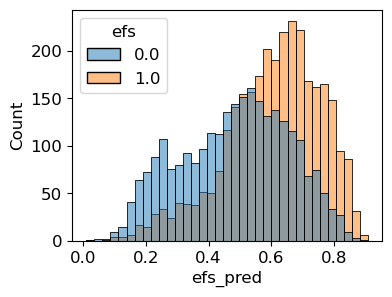

In [326]:
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [ ]:
y_pred = model.predict(x_test)
x_train_sample = x_train.sample(1000).values
ffnn_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = ffnn_shap.shap_values(x_test.values)
shap_vals = shap.Explanation(shap_vals.values, feature_names=x_train.columns.values, data=x_test.values, base_values=model.predict(x_train_sample).mean())

In [ ]:
shap.plots.beeswarm(shap_vals)

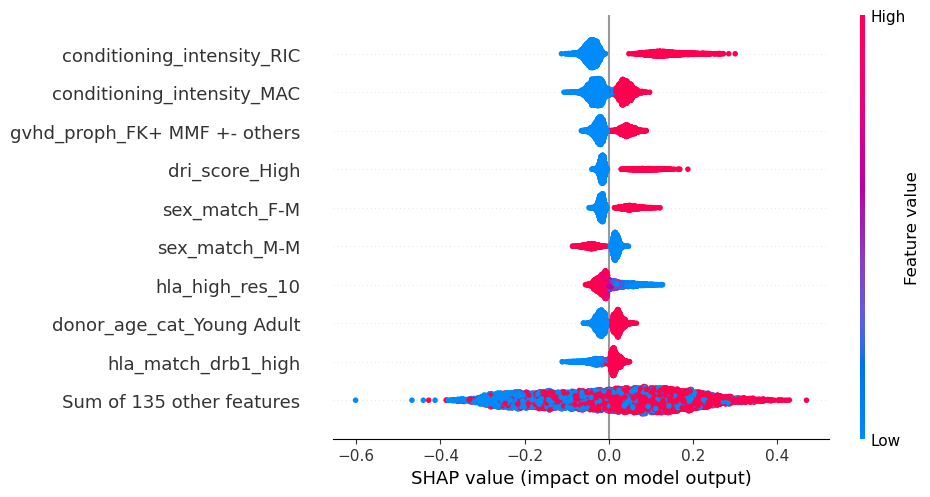

In [89]:
shap.plots.beeswarm(shap_vals)

In [97]:
y_pred_int = y_pred.round().reshape(-1)

tp = [y_test.values[i] == y_pred_int[i] if y_pred_int[i] == 1 else False for i in range(y_test.shape[0])]
tn = [y_test.values[i] == y_pred_int[i] if y_pred_int[i] == 0 else False for i in range(y_test.shape[0])]
fp = [y_test.values[i] != y_pred_int[i] if y_pred_int[i] == 1 else False for i in range(y_test.shape[0])]
fn = [y_test.values[i] != y_pred_int[i] if y_pred_int[i] == 0 else False for i in range(y_test.shape[0])]

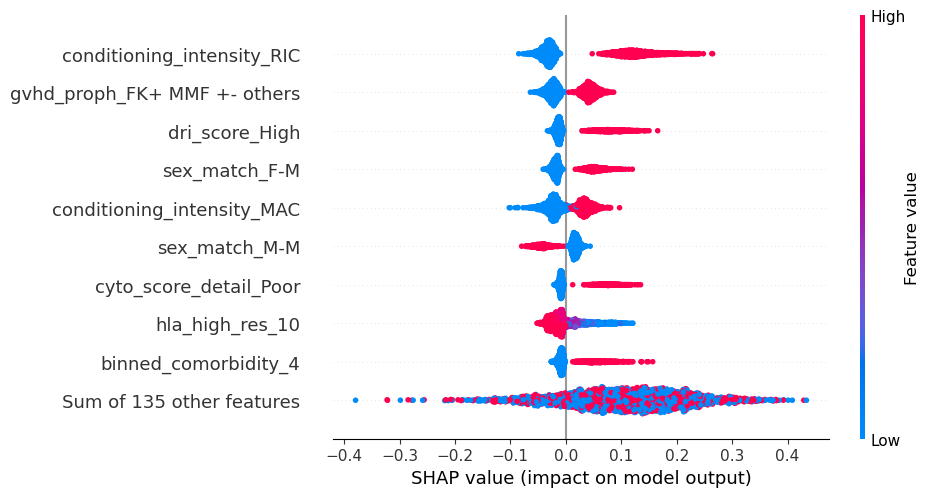

In [100]:
shap.plots.beeswarm(shap_vals[tp])

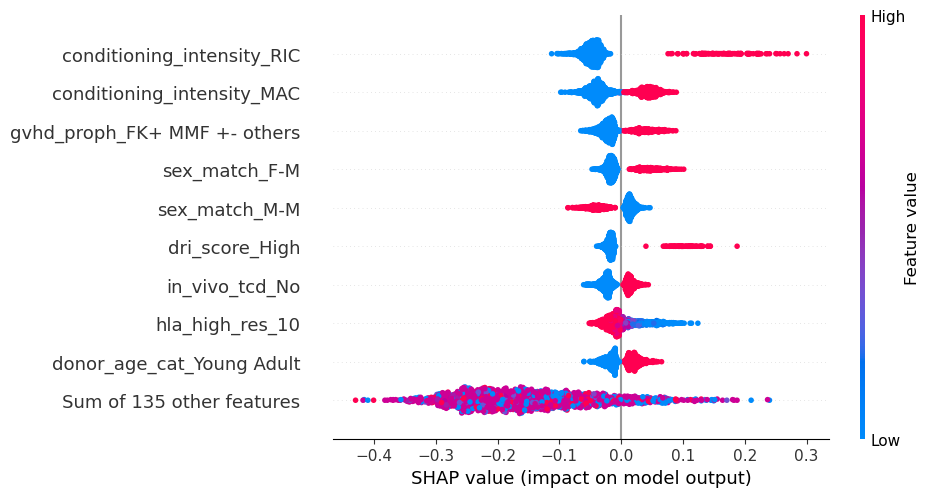

In [101]:
shap.plots.beeswarm(shap_vals[tn])

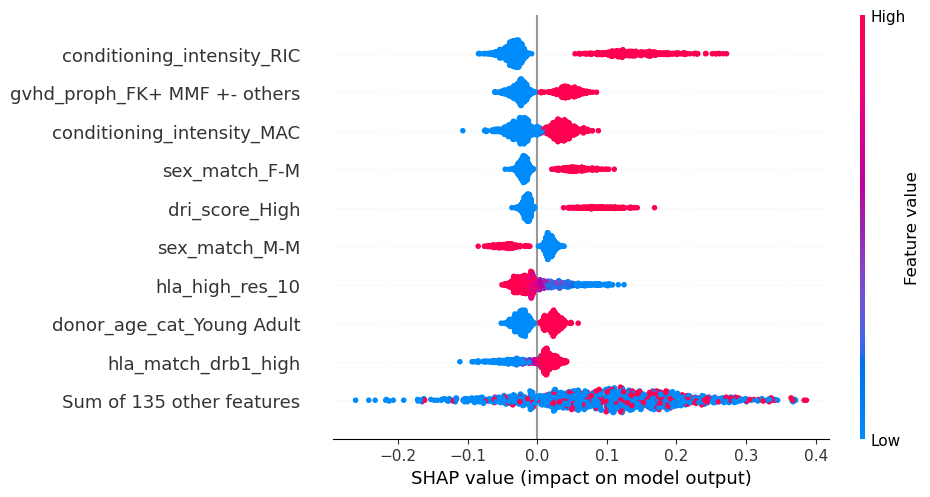

In [102]:
shap.plots.beeswarm(shap_vals[fp])

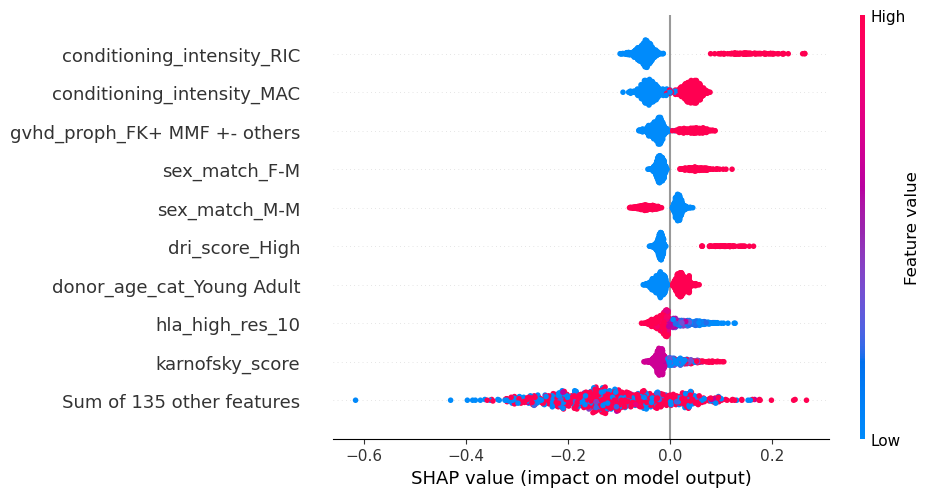

In [103]:
shap.plots.beeswarm(shap_vals[fn])

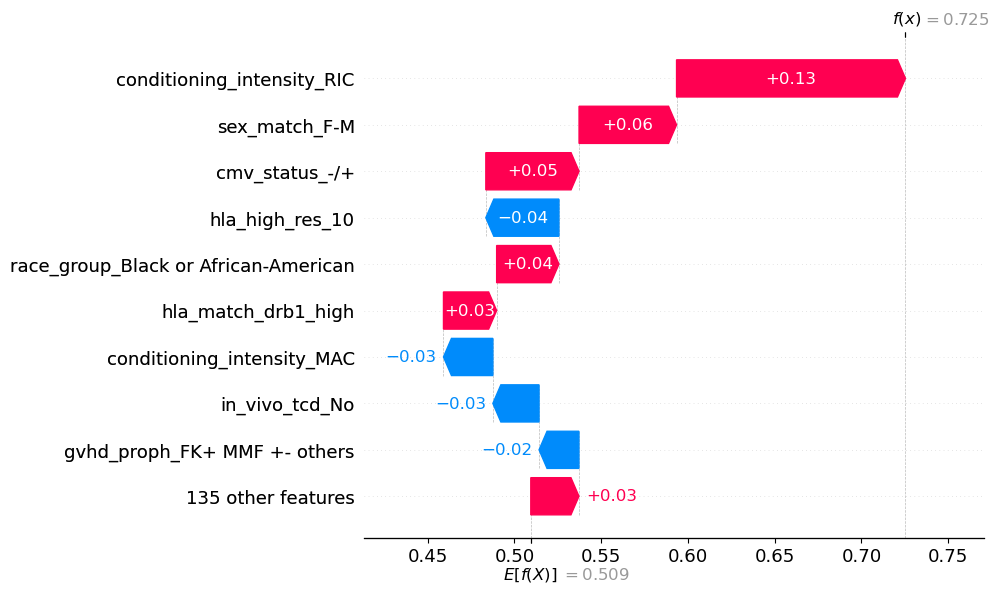

In [73]:
i = 10
val = shap.Explanation(shap_vals[i].values, feature_names=x_train.columns.values, base_values=base_vals.mean())
shap.plots.waterfall(val)

### efs_time as Target

In [258]:
def preprocess_ffnn(df):
    risk_features = FeatureUnion([
        ('risk_cat', CategoricalTransformer(columns=['cyto_score', 'cyto_score_detail', 'binned_comorbidity', 'dri_score'])),
        ('risk_num', NumericalTransformer(columns=['karnofsky_score']))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'donor_related'])),
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list()))
    ])
    risk_pipe = Pipeline([
        ('features', risk_features),
        ('knn_impute', KNNImputer())
    ])
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_severe', 'pt_sex', 
                                                     'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'prim_disease_hct',
                                                     'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate', 'ethnicity', 'race_group'])),
            ('patient_num', NumericalTransformer(columns=['dr_sex_match']))
        ]))
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('knn_impute', KNNImputer())
    ])
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'melphalan_dose', 'age_at_hct_cat', 'rituximab', 
                                                        'conditioning_intensity', 'gvhd_proph'])),
            ('hct_num', NumericalTransformer(columns=['donor-pt_age']))
        ]))
    ])

    risk_df = risk_pipe.fit_transform(df)
    patient_df = patient_pipe.fit_transform(df)
    dr_df = dr_pipe.fit_transform(df)
    hct_df = hct_pipe.fit_transform(df)
    
    risk_cols = []
    risk_trans = ['risk_cat', 'risk_num']
    for trans in risk_trans:
        risk_cols.extend(risk_pipe['features'][trans].transform(df).columns.values)

    patient_cols = []
    patient_trans = ['patient_cat', 'patient_num']
    for trans in patient_trans:
        patient_cols.extend(patient_pipe['features'][trans].transform(df).columns.values)

    dr_cols = []
    dr_trans = ['dr_cat', 'dr_num']
    for trans in dr_trans:
        dr_cols.extend(dr_pipe['features'][trans].transform(df).columns.values)

    hct_cols = []
    hct_trans = ['hct_cat', 'hct_num']
    for trans in hct_trans:
        hct_cols.extend(hct_pipe['features'][trans].transform(df).columns.values)

    risk_df = pd.DataFrame(risk_df, columns=risk_cols)
    patient_df = pd.DataFrame(patient_df, columns=patient_cols)
    dr_df = pd.DataFrame(dr_df, columns=dr_cols)
    hct_df = pd.DataFrame(hct_df, columns=hct_cols)
    
    return (risk_pipe, patient_pipe, dr_pipe, hct_pipe), (risk_df, patient_df, dr_df, hct_df)

In [260]:
x_train, x_test, y_train, y_test = train_test_split(df, df['efs_time'], test_size=0.2)
(risk_pipe, patient_pipe, dr_pipe, hct_pipe), (riskx_train, patientx_train, drx_train, hctx_train) = preprocess_ffnn(x_train)
riskx_test, patientx_test, drx_test, hctx_test = risk_pipe.transform(x_test), patient_pipe.transform(x_test), dr_pipe.transform(x_test), hct_pipe.transform(x_test)
riskx_test, patientx_test = pd.DataFrame(riskx_test, columns=riskx_train.columns.values), pd.DataFrame(patientx_test, columns=patientx_train.columns.values)
drx_test, hctx_test = pd.DataFrame(drx_test, columns=drx_train.columns.values), pd.DataFrame(hctx_test, columns=hctx_train.columns.values)

x_train = pd.concat([riskx_train, patientx_train, drx_train, hctx_train], axis=1)
x_test = pd.concat([riskx_test, patientx_test, drx_test, hctx_test], axis=1)

In [286]:
int1, int2, int3, int4 = riskx_train.shape[1], patientx_train.shape[1], drx_train.shape[1], hctx_train.shape[1]
base_input = layers.Input(shape=(int1+int2+int3+int4,))

input_risk = layers.Lambda(lambda x: x[:,:int1])(base_input)
input_patient = layers.Lambda(lambda x: x[:,int1:int1+int2])(base_input)
input_dr = layers.Lambda(lambda x: x[:,int1+int2:int1+int2+int3])(base_input)
input_hct = layers.Lambda(lambda x: x[:,int1+int2+int3:])(base_input)

x_risk = layers.Dense(int(int1/2),activation='relu')(input_risk)
x_risk = layers.BatchNormalization()(x_risk)
x_risk = layers.Dense(5,activation='relu')(x_risk)
x_risk = layers.Dropout(0.2)(x_risk)

x_patient = layers.Dense(int(int2/3),activation='relu')(input_patient)
x_patient = layers.BatchNormalization()(x_patient)
x_patient = layers.Dense(5,activation='relu')(x_patient)
x_patient = layers.Dropout(0.2)(x_patient)

x_dr = layers.Dense(int(int3/3),activation='relu')(input_dr)
x_dr = layers.BatchNormalization()(x_dr)
x_dr = layers.Dense(5,activation='relu')(x_dr)
x_dr = layers.Dropout(0.2)(x_dr)

x_hct = layers.Dense(int(int4/3),activation='relu')(input_hct)
x_hct = layers.BatchNormalization()(x_hct)
x_hct = layers.Dense(5,activation='relu')(x_hct)
x_hct = layers.Dropout(0.2)(x_hct)

z = layers.Concatenate(axis=1)([x_risk, x_patient, x_dr, x_hct])
z = layers.Dense(15, activation='relu')(z)
z = layers.BatchNormalization()(z)
z = layers.Dense(5, activation='relu')(z)
z = layers.BatchNormalization()(z)
output = layers.Dense(1, activation='relu')(z)

model = keras.Model(inputs=base_input, outputs=output, name='ffnn_model1')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mse', 'mae']
)

Model: "ffnn_model1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_32 (InputLayer)       [(None, 140)]                0         []                            
                                                                                                  
 lambda_124 (Lambda)         (None, 21)                   0         ['input_32[0][0]']            
                                                                                                  
 lambda_125 (Lambda)         (None, 53)                   0         ['input_32[0][0]']            
                                                                                                  
 lambda_126 (Lambda)         (None, 36)                   0         ['input_32[0][0]']            
                                                                                        

In [287]:
callback_a = ModelCheckpoint(filepath = '../models/ffnn_model1.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [288]:
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test), callbacks=[callback_a, callback_b]);

Epoch 1/100
90/90 [==============================] - 6s 13ms/step - loss: 22.4928 - mse: 1118.7144 - mae: 22.4928 - val_loss: 22.8250 - val_mse: 1145.7201 - val_mae: 22.8250
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 21.7293 - mse: 1084.7817 - mae: 21.7293 - val_loss: 21.7145 - val_mse: 1097.0363 - val_mae: 21.7145
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 20.9265 - mse: 1048.1516 - mae: 20.9265 - val_loss: 20.3786 - val_mse: 1034.8420 - val_mae: 20.3786
Epoch 4/100
90/90 [==============================] - 1s 8ms/step - loss: 20.1219 - mse: 1009.7897 - mae: 20.1219 - val_loss: 19.0742 - val_mse: 962.2938 - val_mae: 19.0742
Epoch 5/100
90/90 [==============================] - 1s 8ms/step - loss: 19.3742 - mse: 968.3130 - mae: 19.3742 - val_loss: 18.2601 - val_mse: 898.7070 - val_mae: 18.2601
Epoch 6/100
90/90 [==============================] - 1s 8ms/step - loss: 18.7644 - mse: 930.4481 - mae: 18.7644 - val_loss: 18.0773 - val

In [289]:
# mse, efs_time
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 15.566252708435059
mse: 644.1758422851562
mae: 15.566252708435059
val_loss: 16.124189376831055
val_mse: 679.261962890625
val_mae: 16.124189376831055


180/180 [==============================] - 1s 3ms/step


C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='efs_time', ylabel='Count'>

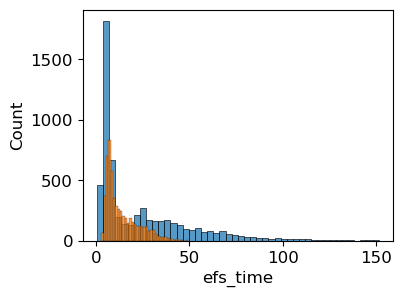

In [290]:
y_pred = model.predict(x_test).reshape(-1)
sns.histplot(y_test)
sns.histplot(y_pred)

In [ ]:
sns.histplot(y_pred, hue=y_test_efs)

In [292]:
y_test_efs = df.loc[y_test.index, 'efs']

In [306]:
df_pred = pd.concat([y_test, y_test_efs], axis=1)
df_pred['efs_time_pred'] = y_pred

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_time_pred', ylabel='Count'>

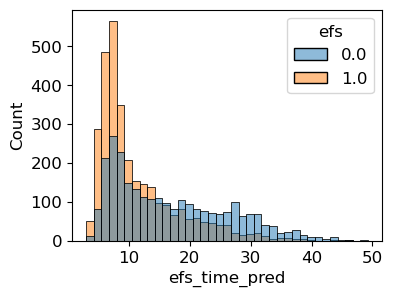

In [308]:
sns.histplot(df_pred, x='efs_time_pred', hue='efs')

### Kaplan Meier survival as target

In [327]:
def preprocess_ffnn(df):
    risk_features = FeatureUnion([
        ('risk_cat', CategoricalTransformer(columns=['cyto_score', 'cyto_score_detail', 'binned_comorbidity', 'dri_score'])),
        ('risk_num', NumericalTransformer(columns=['karnofsky_score']))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'donor_related'])),
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list()))
    ])
    risk_pipe = Pipeline([
        ('features', risk_features),
        ('knn_impute', KNNImputer())
    ])
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_severe', 'pt_sex', 
                                                     'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'prim_disease_hct',
                                                     'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate', 'ethnicity', 'race_group'])),
            ('patient_num', NumericalTransformer(columns=['dr_sex_match']))
        ]))
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('knn_impute', KNNImputer())
    ])
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'melphalan_dose', 'age_at_hct_cat', 'rituximab', 
                                                        'conditioning_intensity', 'gvhd_proph'])),
            ('hct_num', NumericalTransformer(columns=['donor-pt_age']))
        ]))
    ])

    risk_df = risk_pipe.fit_transform(df)
    patient_df = patient_pipe.fit_transform(df)
    dr_df = dr_pipe.fit_transform(df)
    hct_df = hct_pipe.fit_transform(df)
    
    risk_cols = []
    risk_trans = ['risk_cat', 'risk_num']
    for trans in risk_trans:
        risk_cols.extend(risk_pipe['features'][trans].transform(df).columns.values)

    patient_cols = []
    patient_trans = ['patient_cat', 'patient_num']
    for trans in patient_trans:
        patient_cols.extend(patient_pipe['features'][trans].transform(df).columns.values)

    dr_cols = []
    dr_trans = ['dr_cat', 'dr_num']
    for trans in dr_trans:
        dr_cols.extend(dr_pipe['features'][trans].transform(df).columns.values)

    hct_cols = []
    hct_trans = ['hct_cat', 'hct_num']
    for trans in hct_trans:
        hct_cols.extend(hct_pipe['features'][trans].transform(df).columns.values)

    risk_df = pd.DataFrame(risk_df, columns=risk_cols)
    patient_df = pd.DataFrame(patient_df, columns=patient_cols)
    dr_df = pd.DataFrame(dr_df, columns=dr_cols)
    hct_df = pd.DataFrame(hct_df, columns=hct_cols)
    
    return (risk_pipe, patient_pipe, dr_pipe, hct_pipe), (risk_df, patient_df, dr_df, hct_df)

In [328]:
x_train, x_test, y_train, y_test = train_test_split(df, df['y_km'], test_size=0.2)
(risk_pipe, patient_pipe, dr_pipe, hct_pipe), (riskx_train, patientx_train, drx_train, hctx_train) = preprocess_ffnn(x_train)
riskx_test, patientx_test, drx_test, hctx_test = risk_pipe.transform(x_test), patient_pipe.transform(x_test), dr_pipe.transform(x_test), hct_pipe.transform(x_test)
riskx_test, patientx_test = pd.DataFrame(riskx_test, columns=riskx_train.columns.values), pd.DataFrame(patientx_test, columns=patientx_train.columns.values)
drx_test, hctx_test = pd.DataFrame(drx_test, columns=drx_train.columns.values), pd.DataFrame(hctx_test, columns=hctx_train.columns.values)

x_train = pd.concat([riskx_train, patientx_train, drx_train, hctx_train], axis=1)
x_test = pd.concat([riskx_test, patientx_test, drx_test, hctx_test], axis=1)

In [329]:
int1, int2, int3, int4 = riskx_train.shape[1], patientx_train.shape[1], drx_train.shape[1], hctx_train.shape[1]
base_input = layers.Input(shape=(int1+int2+int3+int4,))

input_risk = layers.Lambda(lambda x: x[:,:int1])(base_input)
input_patient = layers.Lambda(lambda x: x[:,int1:int1+int2])(base_input)
input_dr = layers.Lambda(lambda x: x[:,int1+int2:int1+int2+int3])(base_input)
input_hct = layers.Lambda(lambda x: x[:,int1+int2+int3:])(base_input)

x_risk = layers.Dense(int(int1/2),activation='relu')(input_risk)
x_risk = layers.BatchNormalization()(x_risk)
x_risk = layers.Dense(5,activation='relu')(x_risk)
x_risk = layers.Dropout(0.2)(x_risk)

x_patient = layers.Dense(int(int2/3),activation='relu')(input_patient)
x_patient = layers.BatchNormalization()(x_patient)
x_patient = layers.Dense(5,activation='relu')(x_patient)
x_patient = layers.Dropout(0.2)(x_patient)

x_dr = layers.Dense(int(int3/3),activation='relu')(input_dr)
x_dr = layers.BatchNormalization()(x_dr)
x_dr = layers.Dense(5,activation='relu')(x_dr)
x_dr = layers.Dropout(0.2)(x_dr)

x_hct = layers.Dense(int(int4/3),activation='relu')(input_hct)
x_hct = layers.BatchNormalization()(x_hct)
x_hct = layers.Dense(5,activation='relu')(x_hct)
x_hct = layers.Dropout(0.2)(x_hct)

z = layers.Concatenate(axis=1)([x_risk, x_patient, x_dr, x_hct])
z = layers.Dense(15, activation='relu')(z)
z = layers.BatchNormalization()(z)
z = layers.Dense(5, activation='relu')(z)
z = layers.BatchNormalization()(z)
output = layers.Dense(1, activation='relu')(z)

model = keras.Model(inputs=base_input, outputs=output, name='ffnn_model1')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mse', 'mae']
)

Model: "ffnn_model1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 140)]                0         []                            
                                                                                                  
 lambda_132 (Lambda)         (None, 21)                   0         ['input_34[0][0]']            
                                                                                                  
 lambda_133 (Lambda)         (None, 53)                   0         ['input_34[0][0]']            
                                                                                                  
 lambda_134 (Lambda)         (None, 36)                   0         ['input_34[0][0]']            
                                                                                        

In [330]:
callback_a = ModelCheckpoint(filepath = '../models/ffnn_model1.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [331]:
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test), callbacks=[callback_a, callback_b]);

Epoch 1/100
90/90 [==============================] - 7s 14ms/step - loss: 0.5127 - mse: 0.4152 - mae: 0.5127 - val_loss: 0.3266 - val_mse: 0.1494 - val_mae: 0.3266
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.3270 - mse: 0.1673 - mae: 0.3270 - val_loss: 0.1960 - val_mse: 0.0508 - val_mae: 0.1960
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.2193 - mse: 0.0884 - mae: 0.2193 - val_loss: 0.1729 - val_mse: 0.0387 - val_mae: 0.1729
Epoch 4/100
90/90 [==============================] - 1s 7ms/step - loss: 0.1832 - mse: 0.0634 - mae: 0.1832 - val_loss: 0.1555 - val_mse: 0.0347 - val_mae: 0.1555
Epoch 5/100
90/90 [==============================] - 1s 8ms/step - loss: 0.1667 - mse: 0.0517 - mae: 0.1667 - val_loss: 0.1471 - val_mse: 0.0352 - val_mae: 0.1471
Epoch 6/100
90/90 [==============================] - 1s 8ms/step - loss: 0.1580 - mse: 0.0471 - mae: 0.1580 - val_loss: 0.1442 - val_mse: 0.0386 - val_mae: 0.1442
Epoch 7/100
90/90 [==

In [332]:
# mae, y_km
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.12446831911802292
mse: 0.032089658081531525
mae: 0.12446831911802292
val_loss: 0.12456686049699783
val_mse: 0.03274161368608475
val_mae: 0.12456686049699783


180/180 [==============================] - 1s 3ms/step


C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='y_km', ylabel='Count'>

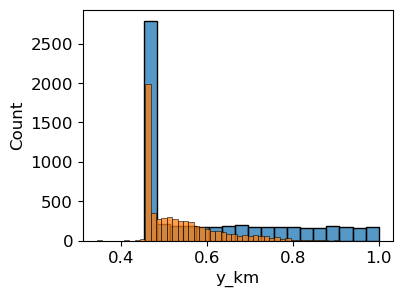

In [333]:
y_pred = model.predict(x_test).reshape(-1)
sns.histplot(y_test)
sns.histplot(y_pred)

In [344]:
df_pred = pd.concat([y_test, df.loc[y_test.index, 'efs'], pd.Series(y_pred, index=y_test.index, name='y_km_pred')], axis=1)

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='y_km_pred', ylabel='Count'>

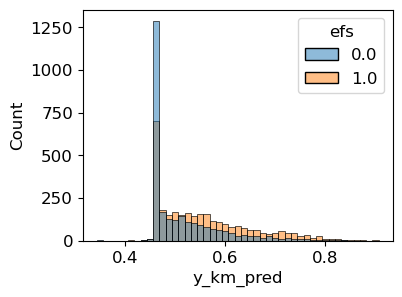

In [345]:
sns.histplot(df_pred, x='y_km_pred', hue='efs')

### Model 2

Applying PCA

**Result:**
- Applying PCA improved performance to ~0.67
- Also tried increasing the depth of the NN. Had minimal impact on accuracy. 
- Too soon to read into SHAP values as model could be better improved first
- Go back to feature engineering to see how I can reduce cardinality of specific features, including prim_disease_hct

In [106]:
def preprocess_ffnn2(df):
    risk_cat = Pipeline([
        ('risk_cat', CategoricalTransformer(columns=['dri_score', 'cyto_score', 'cyto_score_detail'])),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])
    risk_features = FeatureUnion([
        ('pca_cat', risk_cat),
        ('comorb', CategoricalTransformer(columns=['binned_comorbidity'])),
        ('risk_num', NumericalTransformer(columns=['karnofsky_score']))
    ])
    dr_num = Pipeline([
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')])),
        ('knn_impute', KNNImputer()),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])
    dr_features = FeatureUnion([
        ('dr_num', dr_num),
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related']))
    ])
    risk_pipe = Pipeline([
        ('features', risk_features),
        ('knn_impute', KNNImputer())
    ])
    patient_pipe = Pipeline([
        ('features', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct',
                                                     'rituximab', 'conditioning_intensity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor',
                                                     'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate', 'ethnicity', 'race_group'])),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])
    dr_pipe = Pipeline([
        ('features', dr_features)
    ])
    hct_pipe = Pipeline([
        ('features', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'gvhd_proph', 'melphalan_dose', 'age_at_hct_cat', 'donor_age_cat'])),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])

    risk_df = risk_pipe.fit_transform(df)
    patient_df = patient_pipe.fit_transform(df)
    dr_df = dr_pipe.fit_transform(df)
    hct_df = hct_pipe.fit_transform(df)

    risk_cols = ['risk_pca_'+str(i) for i in range(1, risk_pipe['features']['pca_cat']['pca'].components_.shape[0] + 1)]
    risk_cols.extend(risk_pipe['features']['comorb'].transform(df).columns.values)
    risk_cols.extend(risk_pipe['features']['risk_num'].transform(df).columns.values)
    risk_df = pd.DataFrame(risk_df, columns=risk_cols)

    patient_df = pd.DataFrame(patient_df, columns=['patient_pca_'+str(i) for i in range(1, patient_df.shape[1]+1)])
    
    dr_cols = ['dr_pca_'+str(i) for i in range(1, dr_pipe['features']['dr_num']['pca'].components_.shape[0]+1)]
    dr_cols.extend(dr_pipe['features']['dr_cat'].transform(df).columns.values)
    dr_df = pd.DataFrame(dr_df, columns=dr_cols)
    
    hct_df = pd.DataFrame(hct_df, columns=['hct_pca_'+str(i) for i in range(1, hct_df.shape[1]+1)])
    
    return (risk_pipe, patient_pipe, dr_pipe, hct_pipe), (risk_df, patient_df, dr_df, hct_df)

In [107]:
x_train, x_test, y_train, y_test = train_test_split(df, df['efs'], test_size=0.2)
(risk_pipe, patient_pipe, dr_pipe, hct_pipe), (riskx_train, patientx_train, drx_train, hctx_train) = preprocess_ffnn2(x_train)
riskx_test, patientx_test, drx_test, hctx_test = risk_pipe.transform(x_test), patient_pipe.transform(x_test), dr_pipe.transform(x_test), hct_pipe.transform(x_test)
riskx_test, drx_test = pd.DataFrame(riskx_test, columns=riskx_train.columns.values), pd.DataFrame(drx_test, columns=drx_train.columns.values)
patientx_test, hctx_test = pd.DataFrame(patientx_test, columns=patientx_train.columns.values), pd.DataFrame(hctx_test, columns=hctx_train.columns.values)

x_train = pd.concat([riskx_train, patientx_train, drx_train, hctx_train], axis=1)
x_test = pd.concat([riskx_test, patientx_test, drx_test, hctx_test], axis=1)

In [145]:
int1, int2, int3, int4 = riskx_train.shape[1], patientx_train.shape[1], drx_train.shape[1], hctx_train.shape[1]
base_input = layers.Input(shape=(int1+int2+int3+int4,))

input_risk = layers.Lambda(lambda x: x[:,:int1])(base_input)
input_patient = layers.Lambda(lambda x: x[:,int1:int1+int2])(base_input)
input_dr = layers.Lambda(lambda x: x[:,int1+int2:int1+int2+int3])(base_input)
input_hct = layers.Lambda(lambda x: x[:,int1+int2+int3:])(base_input)

x_risk = layers.Dense(int(int1),activation='relu')(input_risk)
x_risk = layers.BatchNormalization()(x_risk)
x_risk = layers.Dropout(0.1)(x_risk)
x_risk = layers.Dense(int(int1/2),activation='relu')(x_risk)
x_risk = layers.BatchNormalization()(x_risk)
x_risk = layers.Dropout(0.1)(x_risk)
x_risk = layers.Dense(7,activation='relu')(x_risk)
x_risk = layers.Dropout(0.1)(x_risk)

x_patient = layers.Dense(int(int2*2/3),activation='relu')(input_patient)
x_patient = layers.BatchNormalization()(x_patient)
x_patient = layers.Dropout(0.1)(x_patient)
x_patient = layers.Dense(int(int2/3),activation='relu')(x_patient)
x_patient = layers.BatchNormalization()(x_patient)
x_patient = layers.Dropout(0.1)(x_patient)
x_patient = layers.Dense(7,activation='relu')(x_patient)
x_patient = layers.Dropout(0.1)(x_patient)

x_dr = layers.Dense(int(int3*2/3),activation='relu')(input_dr)
x_dr = layers.BatchNormalization()(x_dr)
x_dr = layers.Dropout(0.1)(x_dr)
x_dr = layers.Dense(int(int3/3),activation='relu')(x_dr)
x_dr = layers.BatchNormalization()(x_dr)
x_dr = layers.Dropout(0.1)(x_dr)
x_dr = layers.Dense(7,activation='relu')(x_dr)
x_dr = layers.Dropout(0.1)(x_dr)

x_hct = layers.Dense(int(int4),activation='relu')(input_hct)
x_hct = layers.BatchNormalization()(x_hct)
x_hct = layers.Dropout(0.1)(x_hct)
x_hct = layers.Dense(int(int4/2),activation='relu')(x_hct)
x_hct = layers.BatchNormalization()(x_hct)
x_hct = layers.Dropout(0.1)(x_hct)
x_hct = layers.Dense(7,activation='relu')(x_hct)
x_hct = layers.Dropout(0.1)(x_hct)

z = layers.Concatenate(axis=1)([x_risk, x_patient, x_dr, x_hct])
z = layers.BatchNormalization()(z)
z = layers.Dense(14, activation='relu')(z)
z = layers.BatchNormalization()(z)
z = layers.Dense(7, activation='relu')(z)
z = layers.BatchNormalization()(z)
output = layers.Dense(1, activation='sigmoid')(z)

model = keras.Model(inputs=base_input, outputs=output, name='ffnn_model2')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "ffnn_model2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 98)]                 0         []                            
                                                                                                  
 lambda_28 (Lambda)          (None, 17)                   0         ['input_8[0][0]']             
                                                                                                  
 lambda_29 (Lambda)          (None, 33)                   0         ['input_8[0][0]']             
                                                                                                  
 lambda_30 (Lambda)          (None, 31)                   0         ['input_8[0][0]']             
                                                                                        

In [146]:
callback_a = ModelCheckpoint(filepath = '../models/ffnn_model2.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [147]:
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=100, validation_data=(x_test, y_test), callbacks=[callback_a, callback_b]);

Epoch 1/100
90/90 [==============================] - 11s 20ms/step - loss: 0.4673 - accuracy: 0.5645 - mse: 0.2723 - mae: 0.4673 - val_loss: 0.4656 - val_accuracy: 0.5774 - val_mse: 0.2505 - val_mae: 0.4656
Epoch 2/100
90/90 [==============================] - 1s 14ms/step - loss: 0.4110 - accuracy: 0.6158 - mse: 0.2789 - mae: 0.4110 - val_loss: 0.3913 - val_accuracy: 0.6352 - val_mse: 0.2678 - val_mae: 0.3913
Epoch 3/100
90/90 [==============================] - 1s 13ms/step - loss: 0.3772 - accuracy: 0.6401 - mse: 0.2900 - mae: 0.3772 - val_loss: 0.3598 - val_accuracy: 0.6530 - val_mse: 0.2845 - val_mae: 0.3598
Epoch 4/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3624 - accuracy: 0.6459 - mse: 0.2958 - mae: 0.3624 - val_loss: 0.3466 - val_accuracy: 0.6595 - val_mse: 0.2926 - val_mae: 0.3466
Epoch 5/100
90/90 [==============================] - 1s 13ms/step - loss: 0.3543 - accuracy: 0.6520 - mse: 0.2989 - mae: 0.3543 - val_loss: 0.3409 - val_accuracy: 0.6641 - val

In [148]:
# mae
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.310074120759964
accuracy: 0.6905381679534912
mse: 0.2966482639312744
mae: 0.310074120759964
val_loss: 0.3292412757873535
val_accuracy: 0.6713541746139526
val_mse: 0.3169173300266266
val_mae: 0.3292412757873535


In [149]:
# mae
y_pred = model.predict(x_test)
print(y_pred[tp].mean(), y_pred[tp].std(), y_pred[tp].std()/np.sqrt(len(y_pred[tp])))
print(y_pred[tn].mean(), y_pred[tn].std(), y_pred[tn].std()/np.sqrt(len(y_pred[tn])))
print(y_pred[fp].mean(), y_pred[fp].std(), y_pred[fp].std()/np.sqrt(len(y_pred[fp])))
print(y_pred[fn].mean(), y_pred[fn].std(), y_pred[fn].std()/np.sqrt(len(y_pred[fn])))

180/180 [==============================] - 1s 3ms/step
0.9326094 0.23275076 0.004807422606158319
0.12926506 0.31772113 0.00807533630919716
0.8760513 0.30565515 0.009322394726930092
0.24765615 0.40702063 0.014453726310868442


In [137]:
# mse
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.20459921658039093
accuracy: 0.6830295324325562
mse: 0.20459921658039093
mae: 0.4088883697986603
val_loss: 0.20895782113075256
val_accuracy: 0.6736111044883728
val_mse: 0.20895782113075256
val_mae: 0.4114690124988556


In [138]:
# mse
y_pred = model.predict(x_test)
print(y_pred[tp].mean(), y_pred[tp].std(), y_pred[tp].std()/np.sqrt(len(y_pred[tp])))
print(y_pred[tn].mean(), y_pred[tn].std(), y_pred[tn].std()/np.sqrt(len(y_pred[tn])))
print(y_pred[fp].mean(), y_pred[fp].std(), y_pred[fp].std()/np.sqrt(len(y_pred[fp])))
print(y_pred[fn].mean(), y_pred[fn].std(), y_pred[fn].std()/np.sqrt(len(y_pred[fn])))

180/180 [==============================] - 1s 4ms/step
0.70564544 0.11288111 0.0023315378184573317
0.31822798 0.137242 0.003488201573594636
0.65367186 0.11327304 0.0034547953149813
0.38867587 0.13857782 0.0049210426369008416


In [129]:
# mae
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.3152117133140564
accuracy: 0.685460090637207
mse: 0.3014506697654724
mae: 0.3152117133140564
val_loss: 0.3260341286659241
val_accuracy: 0.675000011920929
val_mse: 0.3126324415206909
val_mae: 0.3260341286659241


In [133]:
# mae
y_pred = model.predict(x_test)
print(y_pred[tp].mean(), y_pred[tp].std(), y_pred[tp].std()/np.sqrt(len(y_pred[tp])))
print(y_pred[tn].mean(), y_pred[tn].std(), y_pred[tn].std()/np.sqrt(len(y_pred[tn])))
print(y_pred[fp].mean(), y_pred[fp].std(), y_pred[fp].std()/np.sqrt(len(y_pred[fp])))
print(y_pred[fn].mean(), y_pred[fn].std(), y_pred[fn].std()/np.sqrt(len(y_pred[fn])))

180/180 [==============================] - 0s 3ms/step
0.9416231 0.21268716 0.0043930128921470775
0.11820985 0.30114675 0.007654074696130883
0.88683635 0.29110152 0.008878512980771172
0.2373478 0.40006965 0.014206889970203007


In [112]:
# accuracy
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.5917370915412903
accuracy: 0.6850260496139526
mse: 0.20304815471172333
mae: 0.40651050209999084
val_loss: 0.6060103178024292
val_accuracy: 0.675694465637207
val_mse: 0.20898263156414032
val_mae: 0.4161558747291565


In [150]:
y_pred = model.predict(x_test)
x_train_sample = x_train.sample(1000).values
ffnn_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = ffnn_shap.shap_values(x_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=x_train.columns.values, data=x_test.values, base_values=model.predict(x_train_sample).mean())

180/180 [==============================] - 1s 3ms/step


C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 1s 4ms/step


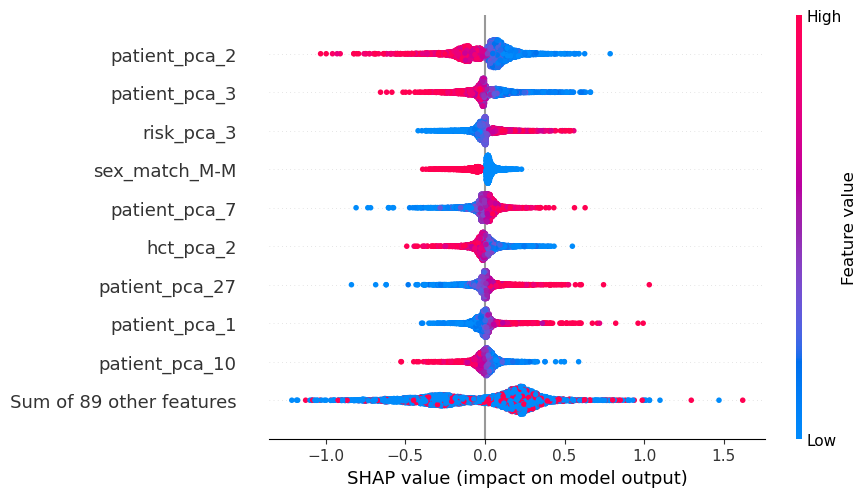

In [151]:
shap.plots.beeswarm(shap_vals)

In [121]:
y_pred_int = y_pred.round().reshape(-1)

tp = [y_test.values[i] == y_pred_int[i] if y_pred_int[i] == 1 else False for i in range(y_test.shape[0])]
tn = [y_test.values[i] == y_pred_int[i] if y_pred_int[i] == 0 else False for i in range(y_test.shape[0])]
fp = [y_test.values[i] != y_pred_int[i] if y_pred_int[i] == 1 else False for i in range(y_test.shape[0])]
fn = [y_test.values[i] != y_pred_int[i] if y_pred_int[i] == 0 else False for i in range(y_test.shape[0])]

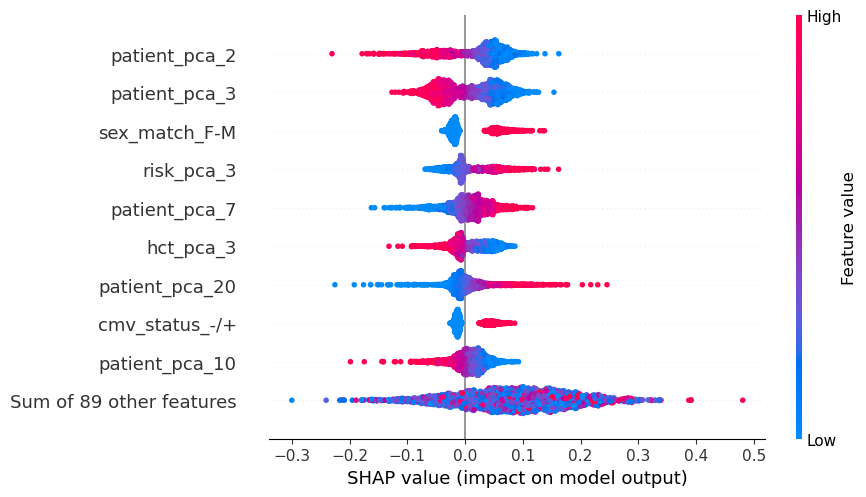

In [122]:
shap.plots.beeswarm(shap_vals[tp])

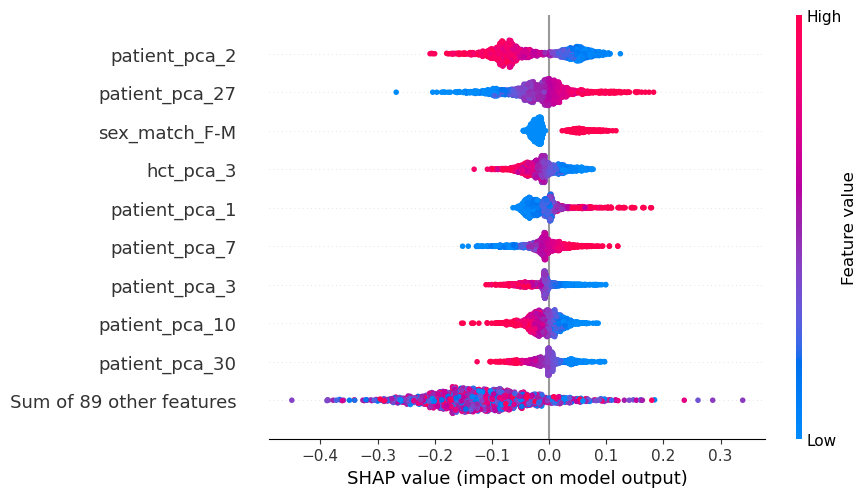

In [123]:
shap.plots.beeswarm(shap_vals[tn])

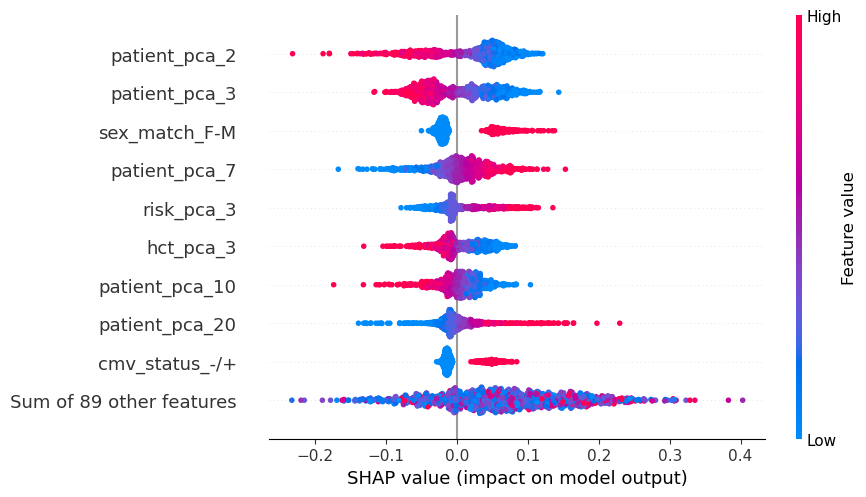

In [124]:
shap.plots.beeswarm(shap_vals[fp])

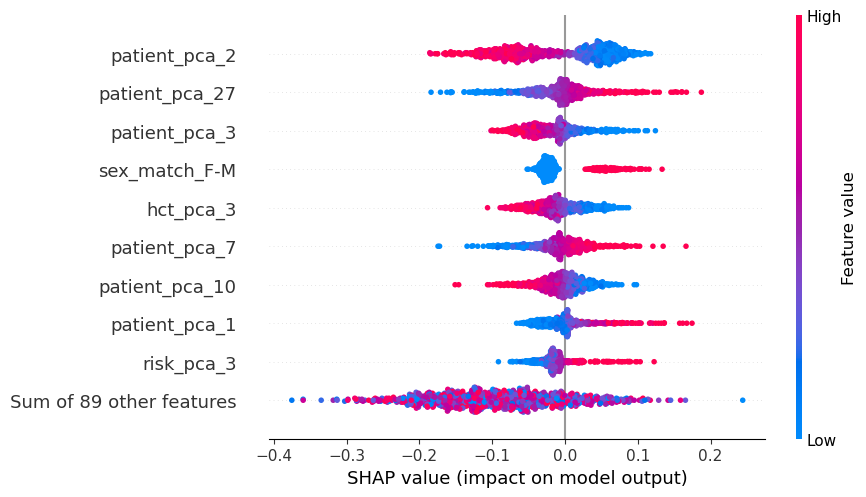

In [125]:
shap.plots.beeswarm(shap_vals[fn])

In [ ]:
i = 10
val = shap.Explanation(shap_vals[i].values, feature_names=x_train.columns.values, base_values=base_vals.mean())
shap.plots.waterfall(val)